In [6]:
from IPython.display import HTML
HTML
HTML("""
<video width=1024 controls>
  <source src="Gosling.mp4" type="video/mp4">
</video>
""")

In [7]:
import cv2
import matplotlib.pyplot as plt
import sys

In [8]:
videoName = "Gosling.mp4"

def drawRect(frame, bbox):
    p1 = (bbox[0], bbox[1])
    p2 = (bbox[0] + bbox[2], bbox[1] + bbox[3])
    cv2.rectangle(frame, p1, p2, (255, 0, 0), 2, 1)
    
def displayRect(frame, bbox):
    plt.figure(figsize = (20, 10))
    frameCopy = frame.copy()
    drawRect(frameCopy, bbox)
    frameCopy = cv2.cvtColor(frameCopy, cv2.COLOR_BGR2RGB)
    plt.imshow(frameCopy); plt.axis('off')
    
def drawText(frame, txt, location, color = (50, 150, 50)):
    cv2.putText(frame, txt, location, cv2.FONT_HERSHEY_SIMPLEX, 1, color, 3)

In [9]:
video = cv2.VideoCapture(videoName)
ok, frame = video.read()

if not video.isOpened():
    print("Couldn't open video")
    sys.exit()
else:
    w = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))
    h = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))


fourcc = cv2.VideoWriter_fourcc(*'mp4v')
fps = video.get(cv2.CAP_PROP_FPS)
width = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))

videoResName = "Gosling_processed.mp4"
videoOut = cv2.VideoWriter(videoResName, fourcc, fps, (width, height))

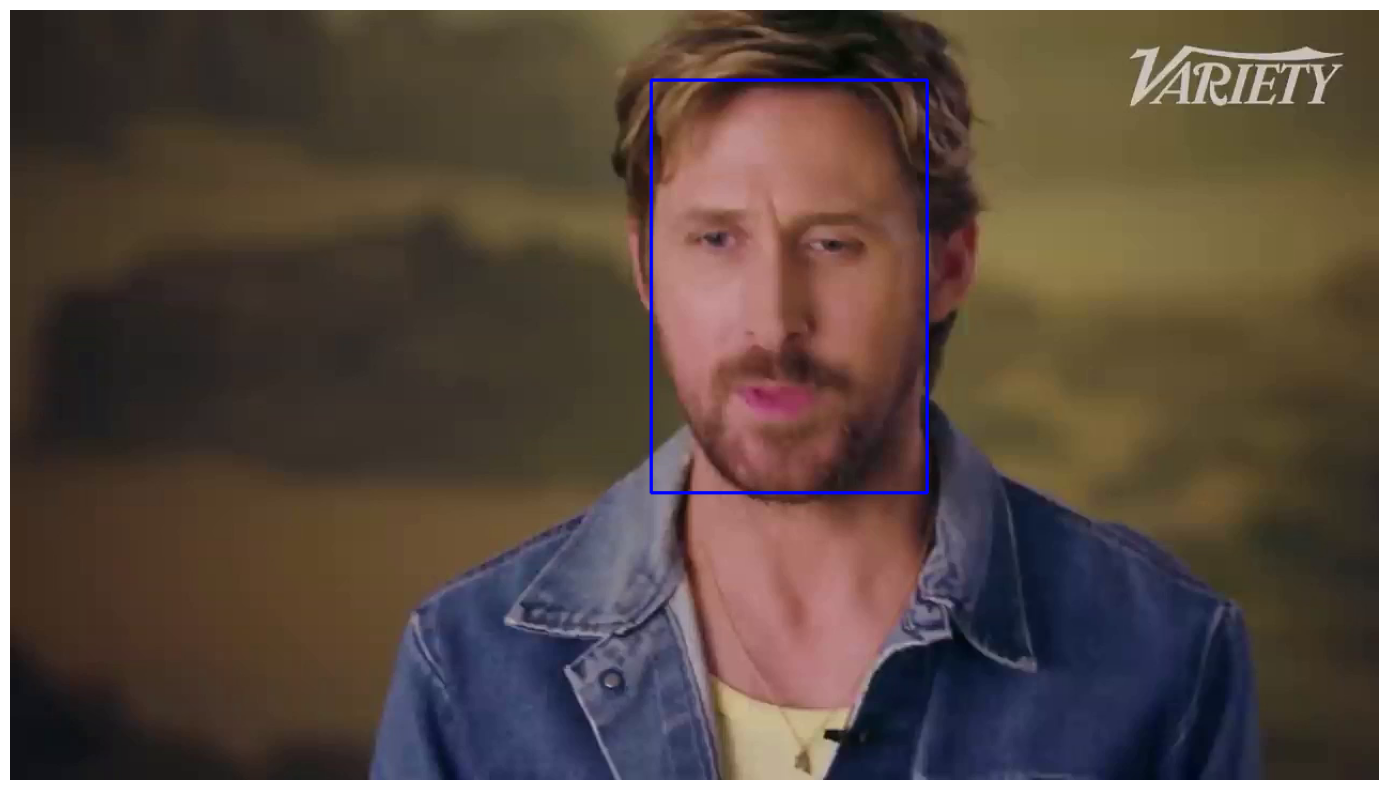

In [10]:
confThresh = 0.9
inputW, inputH = 300, 300
mean = (104.0, 177.0, 123.0)

prototxt_path = "/mnt/d/detect/deploy.prototxt"
model_path = "/mnt/d/detect/res10_300x300_ssd_iter_140000_fp16.caffemodel"
net = cv2.dnn.readNetFromCaffe(prototxt_path, model_path)

ret, img = video.read()

blob = cv2.dnn.blobFromImage(img, 1.0, (inputW, inputH), mean, swapRB=False, crop=False)
net.setInput(blob)
detections = net.forward()
imgH, imgW = img.shape[:2]

for i in range(detections.shape[2]):
    confidence = detections[0, 0, i, 2]
    if confidence > confThresh:
        xLeft = int(detections[0, 0, i, 3] * imgW)
        yLeft = int(detections[0, 0, i, 4] * imgH)
        xRight = int(detections[0, 0, i, 5] * imgW)
        yRight = int(detections[0, 0, i, 6] * imgH)

        bbox0 = (xLeft, yLeft, xRight - xLeft, yRight - yLeft)

displayRect(frame, bbox0)

In [11]:
tracker = cv2.TrackerGOTURN_create()
tracker.init(frame, bbox0)

while True:
    ok, frame = video.read()
    if not ok:
        break
        
    timer = cv2.getTickCount()
    
    ok, bbox = tracker.update(frame)
    fps = cv2.getTickFrequency() / (cv2.getTickCount() - timer)
    
    if ok:
        drawRect(frame, bbox)
    else:
        drawText(frame, "Tracker doesn't find anything", (80, 100), (0, 0, 255))
        
    drawText(frame, "FPS : " + str(int(fps)), (80, 150))
    
    videoOut.write(frame)
    
video.release()
videoOut.release()

print("The video has been processed")

The video has been processed
